In [1]:
import pandas as pd
pd.pandas.set_option('display.max_columns',None)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('../data/average-monthly-surface-temperature.csv')

df.head()

,Entity,Code,year,Day,Average surface temperature,Average surface temperature.1
0,Afghanistan,AFG,1940,1940-01-15,-2.032494,11.327695
1,Afghanistan,AFG,1940,1940-02-15,-0.733503,11.327695
2,Afghanistan,AFG,1940,1940-03-15,1.999134,11.327695
3,Afghanistan,AFG,1940,1940-04-15,10.199754,11.327695
4,Afghanistan,AFG,1940,1940-05-15,17.942135,11.327695


In [3]:
# Переименование столбцов
df = df.rename(columns={
    'Entity': 'Country',
    'year': 'Year',
    'Average surface temperature': 'Daily average temp',
    'Average surface temperature.1': 'Yearly average temp'
})

df = df.drop(columns=['Code'])

# Преобразование столбца Day в формат datetime
df['Day'] = pd.to_datetime(df['Day'])
df['Month'] = df['Day'].dt.month

df.head()

,Country,Year,Day,Daily average temp,Yearly average temp,Month
0,Afghanistan,1940,1940-01-15,-2.032494,11.327695,1
1,Afghanistan,1940,1940-02-15,-0.733503,11.327695,2
2,Afghanistan,1940,1940-03-15,1.999134,11.327695,3
3,Afghanistan,1940,1940-04-15,10.199754,11.327695,4
4,Afghanistan,1940,1940-05-15,17.942135,11.327695,5


          Country  Mean Temp   Min Temp   Max Temp  Std Temp
0     Afghanistan  12.061308  -8.053513  27.249980  9.423564
1         Albania  12.301476  -3.048579  25.224070  6.955465
2         Algeria  22.948630   7.747294  36.700188  7.944168
3  American Samoa  26.524253  24.895966  28.354340  0.542246
4         Andorra   4.823613 -11.127167  17.724030  6.619527
          Country  Mean Temp   Min Temp   Max Temp  Std Temp  Cluster
0     Afghanistan  12.061308  -8.053513  27.249980  9.423564        4
1         Albania  12.301476  -3.048579  25.224070  6.955465        4
2         Algeria  22.948630   7.747294  36.700188  7.944168        2
3  American Samoa  26.524253  24.895966  28.354340  0.542246        1
4         Andorra   4.823613 -11.127167  17.724030  6.619527        0


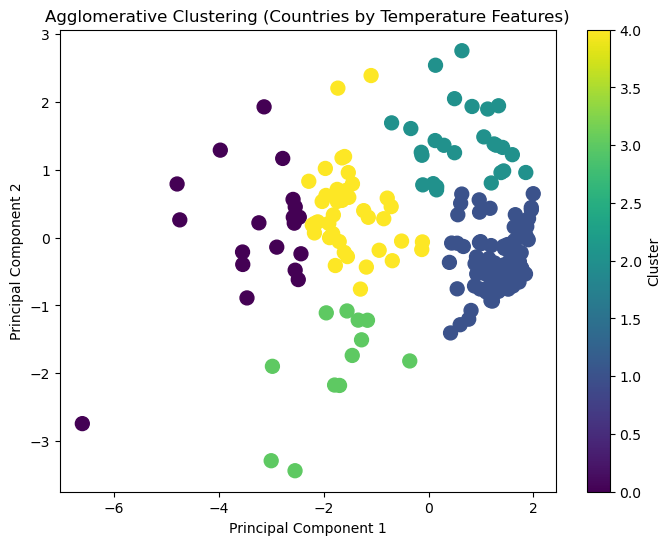

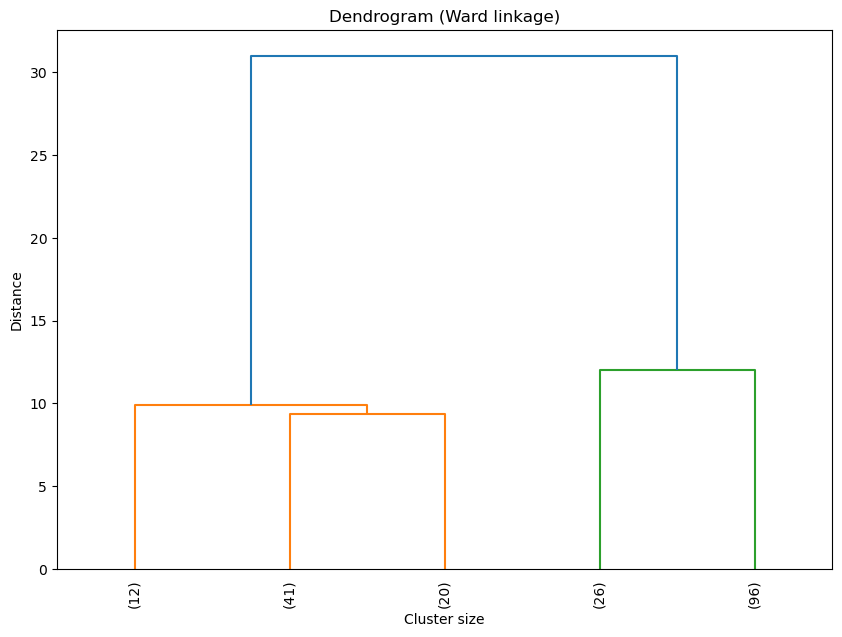

Силуэтовская оценка: 0.49
Индекс Дэвиса-Болдуина: 0.86
Индекс Калински-Харабаса: 228.56


In [4]:
# Агрегируем данные: добавляем дополнительные столбцы
country_avg_temp = df.groupby("Country").agg({
    "Daily average temp": ["mean", "min", "max", "std"]  # Средняя, минимальная, максимальная и стандартное отклонение
}).reset_index()

# Упрощаем названия столбцов
country_avg_temp.columns = ["Country", "Mean Temp", "Min Temp", "Max Temp", "Std Temp"]

# Проверяем агрегированные данные
print(country_avg_temp.head())

# Переход к кластеризации
X = country_avg_temp.drop(columns=["Country"])  # Исключаем название страны
scaler = StandardScaler()  # Стандартизация данных
X_scaled = scaler.fit_transform(X)

# Применяем агломеративную кластеризацию
n_clusters = 5  # Указываем количество кластеров
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
predicted_labels = agg_clustering.fit_predict(X_scaled)

# Добавляем метки кластеров обратно в данные
country_avg_temp["Cluster"] = predicted_labels

# Выводим первые строки с результатами кластеризации
print(country_avg_temp.head())

# Снижение размерности до 2 компонентов для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Визуализация кластеров
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],  # Первая главная компонента
    X_pca[:, 1],  # Вторая главная компонента
    c=predicted_labels,  # Метки кластеров
    s=100,
    cmap='viridis'  # Цветовая схема
)
plt.title("Agglomerative Clustering (Countries by Temperature Features)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")  # Добавляем цветовую легенду
plt.show()

# Визуализация дендрограммы
plt.figure(figsize=(10, 7))
Z = linkage(X_scaled, method='ward')  # Метод Уорда для вычисления расстояний
dendrogram(
    Z,  # Матрица связей
    truncate_mode='lastp',  # Показываем последние кластеры
    p=n_clusters,  # Показываем уровни для n_clusters кластеров
    leaf_rotation=90.,  # Поворот подписей
    leaf_font_size=10.  # Размер шрифта подписей
)
plt.title('Dendrogram (Ward linkage)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

# Вычисление метрик качества кластеризации
silhouette_avg = silhouette_score(X_scaled, predicted_labels)  # Силуэтовская оценка
davies_bouldin = davies_bouldin_score(X_scaled, predicted_labels)  # Индекс Дэвиса-Болдуина
calinski_harabasz = calinski_harabasz_score(X_scaled, predicted_labels)  # Индекс Калински-Харабаса

# Вывод метрик
print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")

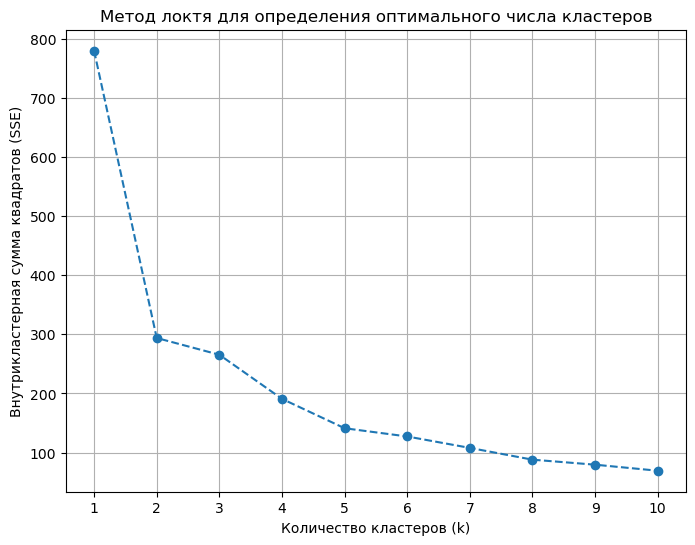

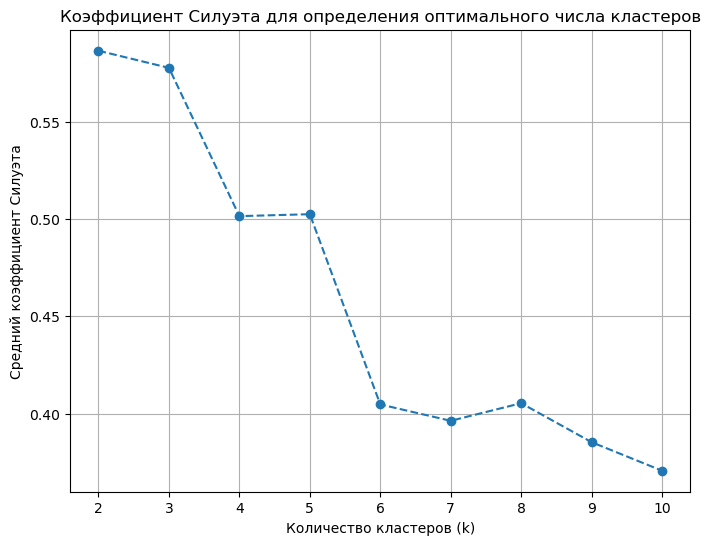

In [5]:
# локоть на основе SSE (внутрикластерной суммы квадратов) 
# Список для сохранения значений SSE
sse = []

# Тестируем количество кластеров от 1 до 10
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)  # Инициализируем KMeans
    kmeans.fit(X_scaled)  # Кластеризация
    sse.append(kmeans.inertia_)  # Сохраняем SSE

# Построение графика "локтя"
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.title("Метод локтя для определения оптимального числа кластеров")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Внутрикластерная сумма квадратов (SSE)")
plt.xticks(k_range)
plt.grid()
plt.show()

# Список для сохранения значений Силуэта
silhouette_scores = []

# Тестируем количество кластеров от 2 до 10
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.title("Коэффициент Силуэта для определения оптимального числа кластеров")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Средний коэффициент Силуэта")
plt.xticks(k_range)
plt.grid()
plt.show()

In [6]:
# Как интерпретировать несколько "локтей" или максимумов?
# Первый максимум:
# Если первый (наименьший) максимум на графике имеет высокий коэффициент Силуэта, это может указывать на то, 
# что данные делятся на небольшое количество крупных кластеров.
# Второй и последующие максимумы:
# Более высокие значения k могут указывать на деление крупных кластеров на более мелкие группы.
# Это полезно, если вы хотите более детализированную сегментацию данных.
# Если значения коэффициента Силуэта для нескольких k близки друг к другу, можно выбрать любое из них, исходя из контекста задачи:
# Если важна интерпретация кластеров, выбирайте меньшее k (более крупные кластеры).
# Если важна точность сегментации, выбирайте большее k (более мелкие кластеры).

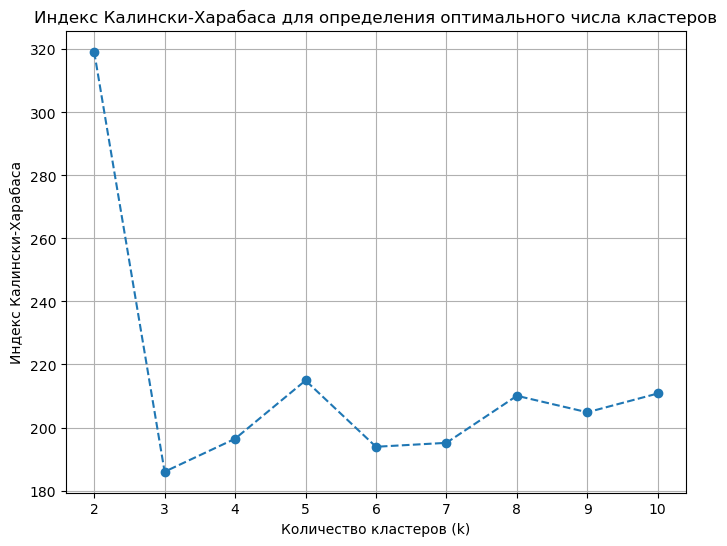

In [7]:
# Индекс Калински-Харабаса:
ch_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    ch_scores.append(calinski_harabasz_score(X_scaled, cluster_labels))

plt.figure(figsize=(8, 6))
plt.plot(k_range, ch_scores, marker='o', linestyle='--')
plt.title("Индекс Калински-Харабаса для определения оптимального числа кластеров")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Индекс Калински-Харабаса")
plt.xticks(k_range)
plt.grid()
plt.show()

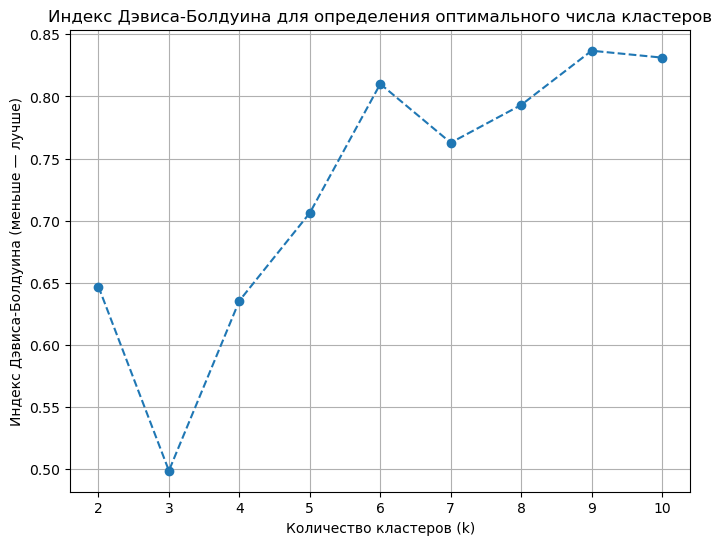

In [8]:
# Индекс Дэвиса-Болдуина:
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    db_scores.append(davies_bouldin_score(X_scaled, cluster_labels))

plt.figure(figsize=(8, 6))
plt.plot(k_range, db_scores, marker='o', linestyle='--')
plt.title("Индекс Дэвиса-Болдуина для определения оптимального числа кластеров")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Индекс Дэвиса-Болдуина (меньше — лучше)")
plt.xticks(k_range)
plt.grid()
plt.show()

          Country  Mean Temp   Min Temp   Max Temp  Std Temp  Cluster
0     Afghanistan  12.061308  -8.053513  27.249980  9.423564        0
1         Albania  12.301476  -3.048579  25.224070  6.955465        0
2         Algeria  22.948630   7.747294  36.700188  7.944168        2
3  American Samoa  26.524253  24.895966  28.354340  0.542246        1
4         Andorra   4.823613 -11.127167  17.724030  6.619527        0


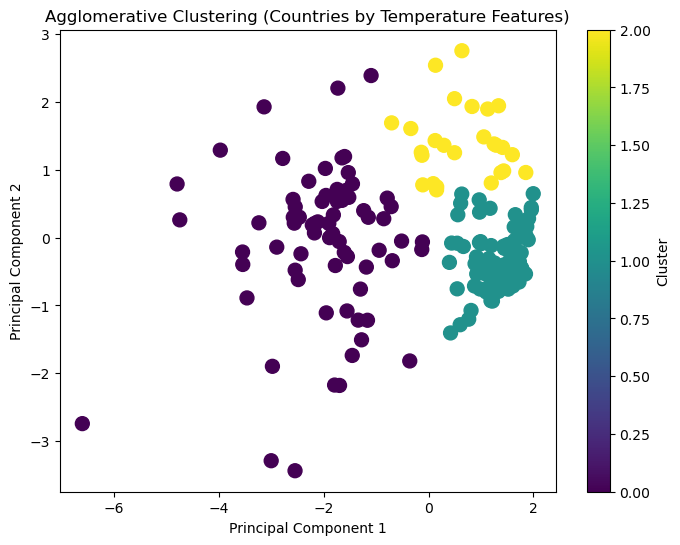

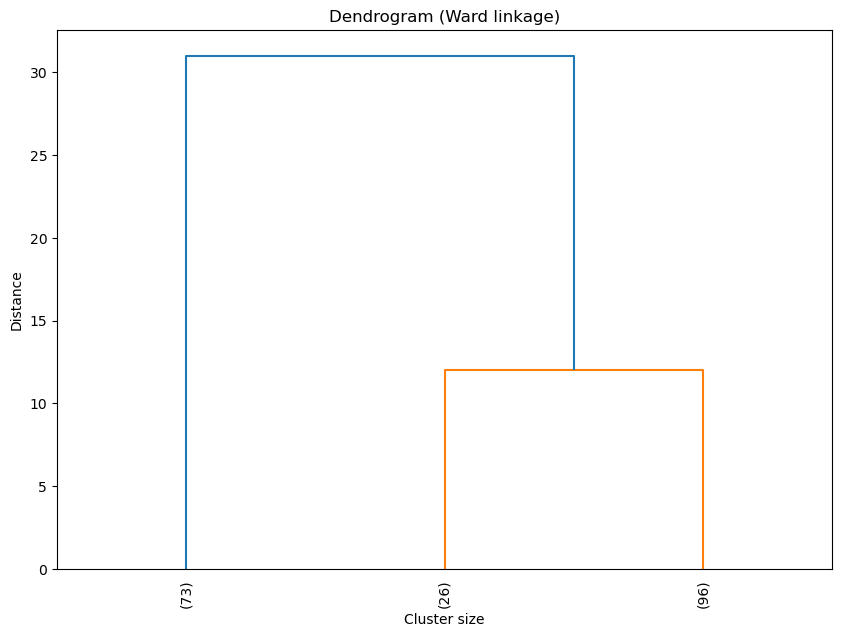

Силуэтовская оценка: 0.51
Индекс Дэвиса-Болдуина: 0.70
Индекс Калински-Харабаса: 233.41


In [9]:
# Применяем агломеративную кластеризацию
n_clusters = 3  # Указываем количество кластеров
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
predicted_labels = agg_clustering.fit_predict(X_scaled)

# Добавляем метки кластеров обратно в данные
country_avg_temp["Cluster"] = predicted_labels

# Выводим первые строки с результатами кластеризации
print(country_avg_temp.head())

# Снижение размерности до 2 компонентов для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Визуализация кластеров
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],  # Первая главная компонента
    X_pca[:, 1],  # Вторая главная компонента
    c=predicted_labels,  # Метки кластеров
    s=100,
    cmap='viridis'  # Цветовая схема
)
plt.title("Agglomerative Clustering (Countries by Temperature Features)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")  # Добавляем цветовую легенду
plt.show()

# Визуализация дендрограммы
plt.figure(figsize=(10, 7))
Z = linkage(X_scaled, method='ward')  # Метод Уорда для вычисления расстояний
dendrogram(
    Z,  # Матрица связей
    truncate_mode='lastp',  # Показываем последние кластеры
    p=n_clusters,  # Показываем уровни для n_clusters кластеров
    leaf_rotation=90.,  # Поворот подписей
    leaf_font_size=10.  # Размер шрифта подписей
)
plt.title('Dendrogram (Ward linkage)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

# Вычисление метрик качества кластеризации
silhouette_avg = silhouette_score(X_scaled, predicted_labels)  # Силуэтовская оценка
davies_bouldin = davies_bouldin_score(X_scaled, predicted_labels)  # Индекс Дэвиса-Болдуина
calinski_harabasz = calinski_harabasz_score(X_scaled, predicted_labels)  # Индекс Калински-Харабаса

# Вывод метрик
print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")

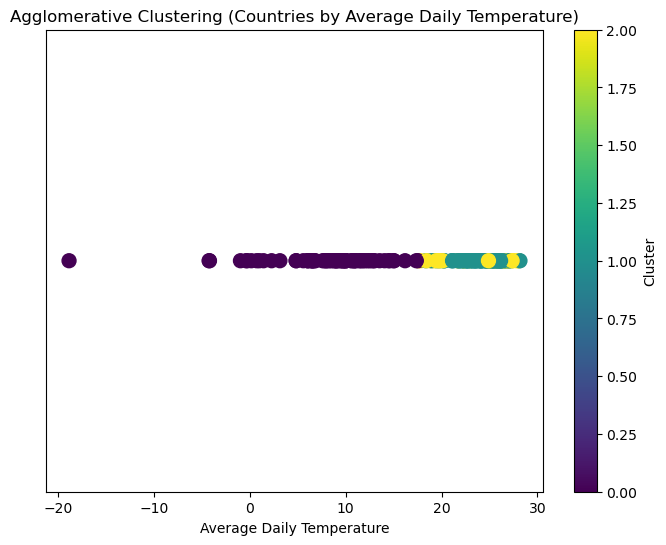

In [10]:
# Визуализация кластеров в одномерном пространстве
plt.figure(figsize=(8, 6))
plt.scatter(
    country_avg_temp["Mean Temp"],  # Средняя температура
    [0] * len(country_avg_temp),  # Все точки по оси Y на одной линии
    c=country_avg_temp["Cluster"],  # Метки кластеров
    s=100,  # Размер точек
    cmap='viridis'  # Цветовая схема
)
plt.title("Agglomerative Clustering (Countries by Average Daily Temperature)")
plt.xlabel("Average Daily Temperature")
plt.yticks([])  # Убираем значения на оси Y, так как они не имеют смысла
plt.colorbar(label="Cluster")  # Добавляем цветовую легенду
plt.show()

          Country  Mean Temp   Min Temp   Max Temp  Std Temp  Cluster
0     Afghanistan  12.061308  -8.053513  27.249980  9.423564        1
1         Albania  12.301476  -3.048579  25.224070  6.955465        1
2         Algeria  22.948630   7.747294  36.700188  7.944168        0
3  American Samoa  26.524253  24.895966  28.354340  0.542246        0
4         Andorra   4.823613 -11.127167  17.724030  6.619527        1


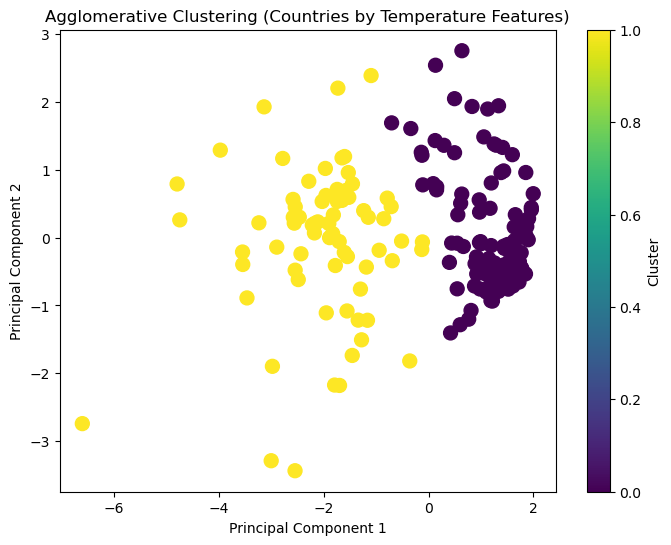

Силуэтовская оценка: 0.58
Индекс Дэвиса-Болдуина: 0.66
Индекс Калински-Харабаса: 309.20


In [11]:
# Применяем агломеративную кластеризацию
n_clusters = 2  # Указываем количество кластеров
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
predicted_labels = agg_clustering.fit_predict(X_scaled)

# Добавляем метки кластеров обратно в данные
country_avg_temp["Cluster"] = predicted_labels

# Выводим первые строки с результатами кластеризации
print(country_avg_temp.head())

# Снижение размерности до 2 компонентов для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Визуализация кластеров
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],  # Первая главная компонента
    X_pca[:, 1],  # Вторая главная компонента
    c=predicted_labels,  # Метки кластеров
    s=100,
    cmap='viridis'  # Цветовая схема
)
plt.title("Agglomerative Clustering (Countries by Temperature Features)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")  # Добавляем цветовую легенду
plt.show()

# Вычисление метрик качества кластеризации
silhouette_avg = silhouette_score(X_scaled, predicted_labels)  # Силуэтовская оценка
davies_bouldin = davies_bouldin_score(X_scaled, predicted_labels)  # Индекс Дэвиса-Болдуина
calinski_harabasz = calinski_harabasz_score(X_scaled, predicted_labels)  # Индекс Калински-Харабаса

# Вывод метрик
print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")
